In [3]:
# data wrangling and linear algebra
import pandas as pd
import numpy as np
import pandas_ta as ta

# data visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib

# metrics
from sklearn import metrics
from sklearn import preprocessing

# yahoo finance api
import yfinance as yf

# statistical tests
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# framework
import tensorflow as tf
from tensorflow.keras import layers, models

# misc
import warnings
import os


warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows',500)
matplotlib.rcParams['figure.figsize']  = (12,8)

In [6]:
# get netflix stock data
stock = yf.Ticker('MSFT')

In [7]:
# get historical market data
hist = stock.history(start = '2010-08-01', end = '2020-07-31', period = '1d')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-08-02,20.48,20.79,20.29,20.75,55044600,0.0,0
2010-08-03,20.65,20.77,20.47,20.62,56877700,0.0,0
2010-08-04,20.61,20.68,20.05,20.28,78531900,0.0,0
2010-08-05,20.09,20.16,19.87,19.99,64922100,0.0,0
2010-08-06,19.84,20.14,19.72,20.14,55982100,0.0,0
...,...,...,...,...,...,...,...
2020-07-24,199.94,202.37,197.03,200.81,39827000,0.0,0
2020-07-27,200.98,203.48,200.38,203.36,30160900,0.0,0
2020-07-28,203.12,204.21,201.25,201.53,23251400,0.0,0


In [8]:
# droppping stock splits and dividends
hist.drop(['Dividends', 'Stock Splits'], axis = 1, inplace=True)
hist.columns =  ['open', 'high', 'low', 'close', 'volume']

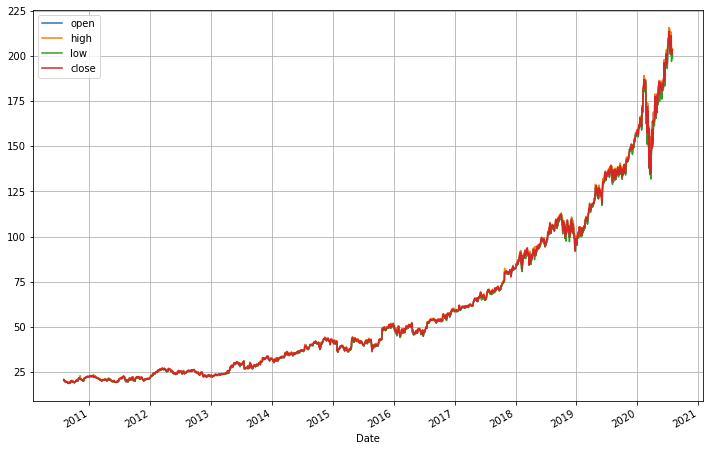

In [9]:
hist.drop('volume', axis = 1).plot(grid = True)
plt.show()

In [10]:
def Calculate_EMA(df, col, exp_moving_average, alpha = 0.7):
    """
    Calculates exponential moving averages and appends to the series data frame.
    
    :param df: dataframe containing the time series (pandas dataframe)
    :parma col: the column for which moving averages to be calculated (str)
    :param moving_average: moving average windows (list of integers)
    
    returns: dataframe with moving averages computed
    """
    df = df.copy()
    for ema in exp_moving_average:
        df[str(ema)+'EMA'] = df[col].ewm(min_periods = ema, alpha = alpha, adjust = False).mean().shift(1)
    
    return df
    

In [11]:
hist = Calculate_EMA(hist, 'close', [10, 30, 50, 100], alpha = 0.7).dropna()

In [12]:
# scaler 
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()

In [13]:
def create_dataset(data, window_size = 50):
    data = data.copy()
    x = []
    y = []
    closep = data['close'].values
    for time in range(len(data)-window_size):
        window_data = data.iloc[time:time+window_size-1,:]
        normalised_window = []
        for col in range(data.shape[1]):
            #norm_col = ((window_data.iloc[:,col] - window_data.iloc[0,col])/(window_data.iloc[0,col])).values
            norm_col = scaler.fit_transform(window_data.iloc[:,col].values.reshape(-1,1)).flatten()
            normalised_window.append(norm_col)
        normalised_window = np.array(normalised_window).T
        x.append(normalised_window)
        
        close_w = closep[time:time+window_size]
        prev_close = close_w[-2]
        next_close = close_w[-1]
        
        if next_close > prev_close:
            y.append(1)
        else:
            y.append(0)
           
    return np.array(x), np.array(y)

def split_data(df, split_time):
    split_index = len(hist.loc[hist.index < split_time])
    train_data = hist.iloc[:split_index]
    val_data = hist.iloc[split_index:]
    
    return split_index, train_data, val_data

split_index, train_data, val_data = split_data(hist, '2019-01-01')

pd.concat([train_data['close'], val_data['close']], axis = 1).plot(grid = True)
plt.legend(['Train', 'Valid'])
plt.show()

In [14]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
   # X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test


In [15]:
# params
window_size = 31
batch_size = 32
epochs = 100
shuffle_buffer = 1000

In [16]:
X,Y = create_dataset(hist, window_size = window_size)
print(X.shape, Y.shape)

(2386, 30, 9) (2386,)


Code Source: https://github.com/Rachnog/Deep-Trading/blob/master/multivariate/utils.py

In [17]:
X_train, X_val, y_train, y_val = create_Xt_Yt(X, Y, 0.8)

In [18]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1908, 30, 9) (478, 30, 9) (1908,) (478,)


In [24]:
tf.keras.backend.clear_session()

# model architecture

model = models.Sequential()
model.add(layers.Conv1D(16, 3, input_shape = [X.shape[1], X.shape[-1]], padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))




model.add(layers.LSTM(50, return_sequences = False))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(50))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())


model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)


model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 16)            448       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 16)            64        
_________________________________________________________________
re_lu (ReLU)                 (None, 30, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                13400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2

In [25]:
history = model.fit(X_train, y_train, epochs = epochs, validation_data=(X_val, y_val)) 

Epoch 1/100
60/60 [==============================] - 1s 11ms/step - loss: 0.7991 - accuracy: 0.5010 - val_loss: 0.7020 - val_accuracy: 0.4351
Epoch 2/100
60/60 [==============================] - 0s 6ms/step - loss: 0.7812 - accuracy: 0.5058 - val_loss: 0.6998 - val_accuracy: 0.4603
Epoch 3/100
60/60 [==============================] - 0s 6ms/step - loss: 0.7556 - accuracy: 0.4942 - val_loss: 0.7019 - val_accuracy: 0.4498
Epoch 4/100
60/60 [==============================] - 0s 6ms/step - loss: 0.7507 - accuracy: 0.5100 - val_loss: 0.7013 - val_accuracy: 0.4561
Epoch 5/100
60/60 [==============================] - 0s 6ms/step - loss: 0.7466 - accuracy: 0.4879 - val_loss: 0.6993 - val_accuracy: 0.4331
Epoch 6/100
60/60 [==============================] - 0s 6ms/step - loss: 0.7417 - accuracy: 0.4906 - val_loss: 0.6950 - val_accuracy: 0.4833
Epoch 7/100
60/60 [==============================] - 0s 7ms/step - loss: 0.7197 - accuracy: 0.5121 - val_loss: 0.6931 - val_accuracy: 0.5146
Epoch 8/100


Epoch 59/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6962 - accuracy: 0.5257 - val_loss: 0.6840 - val_accuracy: 0.5565
Epoch 60/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6986 - accuracy: 0.5100 - val_loss: 0.6844 - val_accuracy: 0.5586
Epoch 61/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.5073 - val_loss: 0.6846 - val_accuracy: 0.5607
Epoch 62/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6970 - accuracy: 0.5220 - val_loss: 0.6838 - val_accuracy: 0.5607
Epoch 63/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.5189 - val_loss: 0.6835 - val_accuracy: 0.5544
Epoch 64/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.5110 - val_loss: 0.6838 - val_accuracy: 0.5586
Epoch 65/100
60/60 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.5173 - val_loss: 0.6846 - val_accuracy: 0.5628
Epoch 

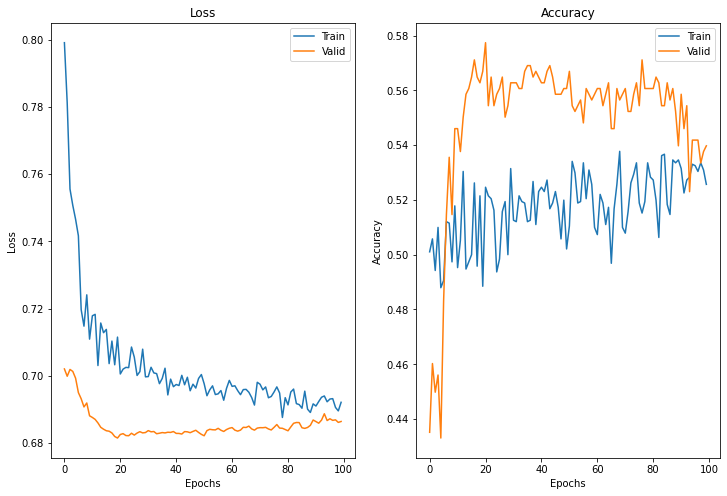

In [26]:
# plotting
plt.subplot(121)
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Valid')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Valid')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
print('Average Accuracy: ', np.mean(history.history['val_accuracy']))

Average Accuracy:  0.5500000011920929


In [30]:
# saving model
model.save('CONV16-LSTM50-D50.pth')

INFO:tensorflow:Assets written to: CONV16-LSTM50-D50.pth\assets


In [4]:
loaded_model = models.load_model('CONV16-LSTM50-D50.pth')

In [27]:
predictions = (loaded_model.predict(X_val)>0.5).astype(int).flatten()

In [30]:
from sklearn import metrics
print(metrics.classification_report(predictions, y_val))

              precision    recall  f1-score   support

           0       0.15      0.40      0.22        77
           1       0.83      0.57      0.67       401

    accuracy                           0.54       478
   macro avg       0.49      0.48      0.45       478
weighted avg       0.72      0.54      0.60       478

